# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

Processing /home/ruslan/.cache/pip/wheels/73/23/af/0b183d0c311bbd174d61613a506bc22c7134eca8878d09aec0/networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)


In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-305.  -435.    85.5    5.     5.    85.5]
 [-295.  -435.    85.5    5.     5.    85.5]
 [-285.  -435.    85.5    5.     5.    85.5]
 ...
 [ 435.   465.     8.     5.     5.     8. ]
 [ 445.   465.     8.     5.     5.     8. ]
 [ 455.   465.     8.     5.     5.     8. ]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [6]:
from sampling import Sampler
sampler = Sampler(data)
polygons = sampler._polygons

In [7]:
# Example: sampling 300 points and removing
# ones conflicting with obstacles.
nodes = sampler.sample(300)
print(len(nodes))

202


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [8]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

In [9]:
from shapely.geometry import Polygon, Point, LineString
import networkx as nx
from sklearn.neighbors import KDTree


class Graph(nx.Graph):

    def __init__(self, nodes, polygons):
        super().__init__()
        self.polygons = polygons
        self.all_nodes = nodes
        
    def can_connect(self, p1,p2):
        line = LineString([p1, p2])
        for p in self.polygons:
            if p.crosses(line) and p.height >= np.min([p1[2], p2[2]]):
                return False
        return True

    def create_graph(self, k):
        self.tree = KDTree(np.array(self.all_nodes), metric='euclidean')
        for n in self.all_nodes:
            # Extract indices of 3 closest points
            idxs = self.tree.query([n], k=k, return_distance=False)[0]  
            for ind in idxs:
                if self.all_nodes[ind] != n:
                    if self.can_connect(n, self.all_nodes[ind]):
                        self.add_edge(n, self.all_nodes[ind], weight=np.linalg.norm(np.array(n)-self.all_nodes[ind]))


In [10]:
g = Graph(nodes, polygons)
g.create_graph(10)

## Step 4 - Visualize Graph

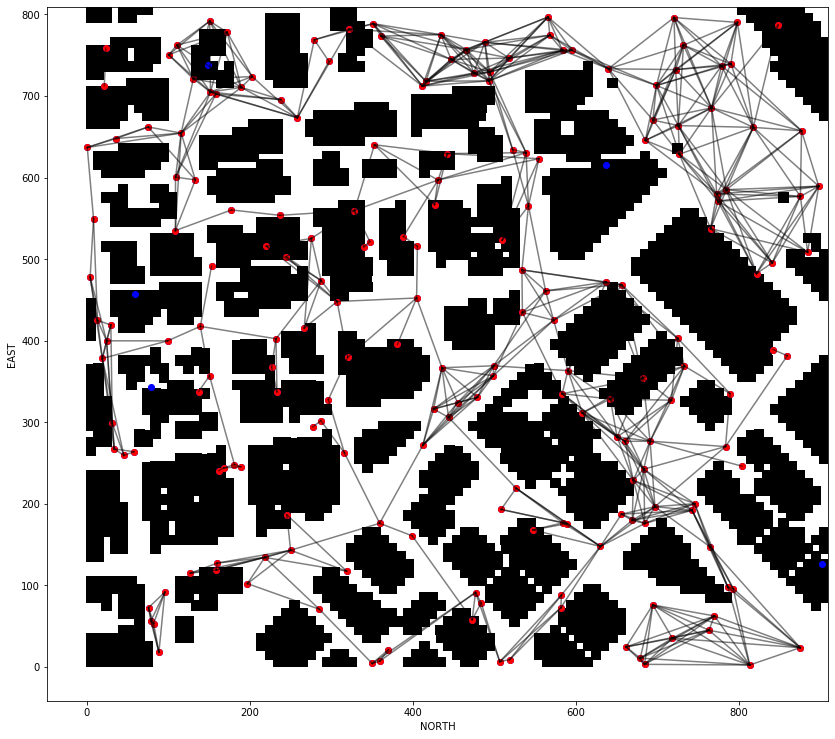

In [11]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [12]:
def heuristic(n1, n2):
    # TODO: complete
    return np.linalg.norm(np.array(n1) - np.array(n2))

## Step 6 - Complete A*

In [13]:
from queue import PriorityQueue


def a_star(graph, h, start, goal):
    """Modified A* to work with NetworkX graphs."""

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:                    
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************')
    
    return np.array(path[::-1]), path_cost

In [14]:
start_ne = (150., 10., 5.) #list(g.nodes)[10]
goal_ne = (700., 700., 5.) #list(g.nodes)[12]

In [15]:
def find_start_goal(graph, start, goal):
    nodes = np.array(graph.nodes)
    start_min_dist = np.linalg.norm(np.array(start) - nodes, axis=1).argmin()
    near_start = nodes[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - nodes, axis=1).argmin()
    near_goal = nodes[goal_min_dist]
    
    return near_start, near_goal        
    
    
graph_start, graph_goal = find_start_goal(g, start_ne, goal_ne)

print(start_ne, goal_ne)
print(graph_start, graph_goal)

(150.0, 10.0, 5.0) (700.0, 700.0, 5.0)
[147.24597829 -30.43591426  12.09223085] [482.13038765 412.97982557  16.10860988]


In [19]:
random_s = np.random.randint(len(g.nodes))
graph_start = list(g.nodes)[random_s]
random_g = np.random.randint(len(g.nodes))
graph_goal = list(g.nodes)[random_g]

In [20]:
path, cost = a_star(g, heuristic, tuple(graph_start), tuple(graph_goal))
print(path, cost)

Found a path.
[[457.3223379  296.91574166   7.13062094]
 [428.40863018 204.84207123  14.63826264]
 [450.9110016  148.57413352   8.05145075]
 [413.59431866  58.36140334   5.39401786]
 [329.2180977   87.33475388   2.05493689]
 [260.2542784  106.7768814   18.12450566]
 [155.9233115  127.77025735   9.9400391 ]] 1655.5570183160937


## Step 7 - Visualize Path

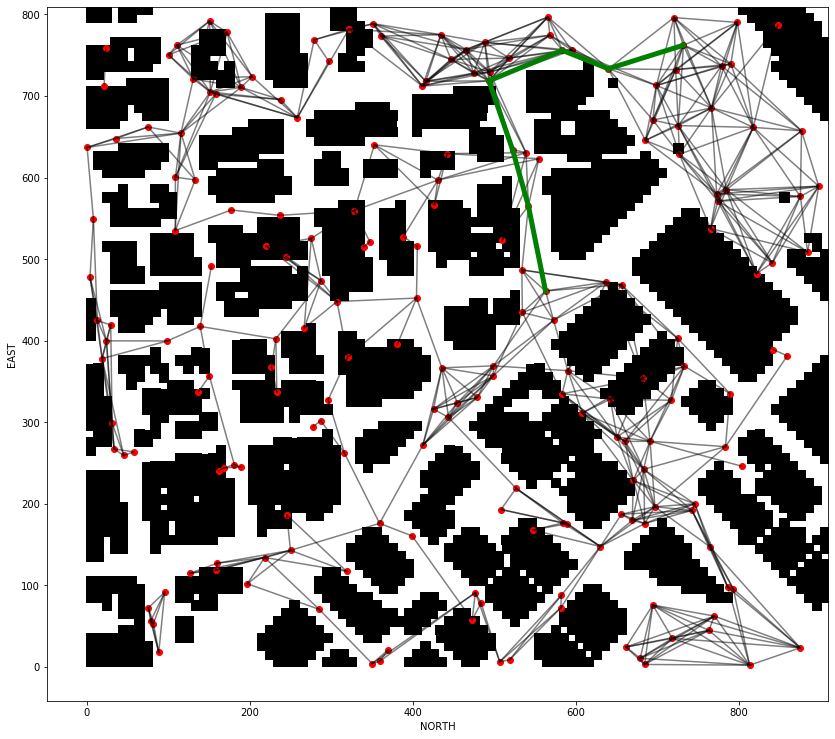

In [21]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')

# Add code to visualize path here
# plt.plot(path[:, 1], path[:, 0], linewidth=5, label='path')
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green', linewidth=5)
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()